# *Question 4*
### **Feed_forward error Back propagation learning for multilayer neural network having one hidden layer**

### Importing useful Libraries

In [23]:
# Importig random library for genrating random numbers for calculating iitial weights
from random import seed
from random import randrange
from random import random
from math import exp
from csv import reader #importing random function to genrate weights
import numpy as np
import pandas as pd

### Load a CSV file

In [2]:
def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset

### Convert string column to integer

In [3]:
def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column].strip())

### Convert string column to float

In [4]:
def str_column_to_int(dataset, column):
    class_values = [row[column] for row in dataset]
    unique = set(class_values)
    lookup = dict()
    for i, value in enumerate(unique):
        lookup[value] = i
    for row in dataset:
        row[column] = lookup[row[column]]
    return lookup

### Find the min and max values for each column

In [5]:
def dataset_minmax(dataset):
    minmax = list()
    stats = [[min(column), max(column)] for column in zip(*dataset)]
    return stats

### Rescale dataset columns to the range 0-1

In [6]:
def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row)-1):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

### Split a dataset into k folds

In [7]:
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

### Calculate accuracy percentage

In [8]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

### Evaluate an algorithm using a cross validation split

In [9]:
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores

### Calculate neuron activation for an input

In [10]:
def activate(weights, inputs):
    activation = weights[-1]
    for i in range(len(weights)-1):
        activation += weights[i] * inputs[i]
    return activation

### Transfer neuron activation

In [11]:
def transfer(activation):
    return 1.0 / (1.0 + exp(-activation))

### Forward propagate input to a network output

In [12]:
def forward_propagate(network, row):
    inputs = row
    for layer in network:
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron['output'] = transfer(activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs
    return inputs

### Calculate the derivative of an neuron output

In [13]:
def transfer_derivative(output):
    return output * (1.0 - output)

### Backpropagate error and store in neurons

In [14]:
def backward_propagate_error(network, expected):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = list()
        if i != len(network)-1:
            for j in range(len(layer)):
                error = 0.0
                for neuron in network[i + 1]:
                    error += (neuron['weights'][j] * neuron['delta'])
                errors.append(error)
        else:
            for j in range(len(layer)):
                neuron = layer[j]
                errors.append(expected[j] - neuron['output'])
        for j in range(len(layer)):
            neuron = layer[j]
            neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

### Update network weights with error

In [15]:
def update_weights(network, row, l_rate):
    for i in range(len(network)):
        inputs = row[:-1]
        if i != 0:
            inputs = [neuron['output'] for neuron in network[i - 1]]
        for neuron in network[i]:
            for j in range(len(inputs)):
                neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
            neuron['weights'][-1] += l_rate * neuron['delta']

### Train a network for a fixed number of epochs

In [16]:
def train_network(network, train, l_rate, n_epoch, n_outputs):
    for epoch in range(n_epoch):
        for row in train:
            outputs = forward_propagate(network, row)
            expected = [0 for i in range(n_outputs)]
            expected[row[-1]] = 1
            backward_propagate_error(network, expected)
            update_weights(network, row, l_rate)

### Initialize a network

In [17]:
def initialize_network(n_inputs, n_hidden, n_outputs):
    network = list()
    hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
    network.append(hidden_layer)
    output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
    network.append(output_layer)
    return network

### Make a prediction with a network

In [18]:
def predict(network, row):
    outputs = forward_propagate(network, row)
    return outputs.index(max(outputs))

### Backpropagation Algorithm With Stochastic Gradient Descent

In [19]:
def back_propagation(train, test, l_rate, n_epoch, n_hidden):
    n_inputs = len(train[0]) - 1
    n_outputs = len(set([row[-1] for row in train]))
    network = initialize_network(n_inputs, n_hidden, n_outputs)
    train_network(network, train, l_rate, n_epoch, n_outputs)
    predictions = list()
    for row in test:
        prediction = predict(network, row)
        predictions.append(prediction)
    return(predictions)

### One Hot Encoding

In [20]:
iris = pd.read_csv("Iris.csv")
iris.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [21]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

Y = iris.Species
Y = one_hot_encoder.fit_transform(np.array(Y).reshape(-1, 1))
Y[:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [24]:
# Test Backprop on Seeds dataset
seed(1)
# load and prepare data
filename = 'Iris1.csv'
dataset = load_csv(filename)
for i in range(len(dataset[0])-1):
    str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)
# normalize input variables
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)
# evaluate algorithm
n_folds = 5
l_rate = 0.3
n_epoch = 500
n_hidden = 5
scores = evaluate_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Scores: [96.66666666666667, 96.66666666666667, 100.0, 93.33333333333333, 96.66666666666667]
Mean Accuracy: 96.667%


### **Question 3**

In [ ]:
import random

class Net:
    def __init__(self, inputD, outputD, weightB):
        i = 1
        x = 0
        self.xneurons = {}
        if weightB == 1:
            x = 1
        while i <= inputD:
            self.xneurons[i] = Neuron(inputD, x)
            i = i + 1
        self.xneurons['b'] = Neuron(inputD, x)
        j = 1
        self.zneurons = {}
        while j <= inputD:
            self.zneurons[j] = Neuron(outputD, 2)
            j = j + 1
        self.zneurons['b'] = Neuron(outputD, 2)
        k = 1
        self.y = {}
        while k <= outputD:
            self.y[k] = 0
            k = k + 1

class Neuron:
    def __init__(self, outputD, weightB):
        i = 1
        self.weights = {}
        self.y = {}
        while i <= outputD:
            self.y[i] = 0
            if int(weightB) == 0:
                self.weights[i] = 0
            # for the hidden layer
            elif weightB is 2:
                self.weights[i] = .5
            else:
                # this needs to be random
                self.weights[i] = random.random();
            i = i + 1
        self.weights[1]
        self.x = 0


class InputVars:
    def __init__(self, input, output, pairs, samples):
        self.input = input
        self.output = output
        self.pairs = pairs
        self.samples = samples


class Sample:
    def __init__(self, inputD, outputD, s, t):
        self.x = {}
        i = 1
        while i <= inputD:
            self.x[i] = s[i - 1]
            i = i + 1
        j = 1
        self.t = {}
        while j <= outputD:
            self.t[j] = int(t)
            j = j + 1


def readFile(filename):
    f = open(filename, 'r')

    inputD = [int(s) for s in f.readline().split() if s.isdigit()]
    inputD = inputD[0]
    outputD = [int(s) for s in f.readline().split() if s.isdigit()]
    outputD = outputD[0]
    tpairs = [int(s) for s in f.readline().split() if s.isdigit()]
    tpairs = tpairs[0]
    f.readline()

    t = 0
    samples = {}
    while t < tpairs:
        s = f.readline().split()
        target = f.readline()
        f.readline()
        tmp = Sample(inputD, outputD, s, target)
        t = t + 1
        samples[t] = tmp
    return InputVars(inputD, outputD, tpairs, samples)

In [70]:
def a1a():
    weights_b = input("Enter 0 to initialize weights to zero, or any other key to set to random values:\n")
    try:
        if int(weights_b) is 0:
            return 0
        else:
            return 1
    except:
        return 1


def a1b():
    max_epochs = input("Enter the maximum number of training epochs:\n")
    try:
        max_epochs = int(max_epochs)
        if max_epochs > 0:
            return max_epochs
        else:
            print("Negative numbers not allowed. Setting max epochs to 5.")
            return 5
    except:
        print("Input failed. Try again.")
        return a1b()


def a1c():
    alpha = input("Enter the desired learning rate:\n")
    try:
        alpha = float(alpha)
        if alpha > 1.0:
            print("Learning rate too large Enter an x value such that 0 < x <= 1.")
        elif alpha <= 0.0:
            print("Learning rate is too small. Enter an x value such that 0 < x <= 1.")
        else:
            return alpha
        return a1c()
    except:
        print("Input failed. Try again.")
        return a1c()


def a1d():
    filename = input("Enter the file name where weights will be saved:")
    return filename


def a1():
    weights_b = a1a()
    max_epochs = a1b()
    learning_rate = a1c()
    weight_file = a1d()

    r = {}
    r['w'] = weights_b
    r['e'] = max_epochs
    r['l'] = learning_rate
    r['f'] = weight_file

    return r


def a(option, data, Net):
    option = int(option)
    if option is 1:
        net_parameters = a1()
        return madaline1(net_parameters, data)
    if option is 2:
        if Net is 0:
            print("You need to train the net before you can deploy it. Try option 1.")
            menu(data, Net)
        else:
            name = input("Enter the file name where the testing/deploying results will be saved:\n")
            madaline2(name, Net, data)
    if option is 3:
        print("Thanks for using this Madaline Neural Network!")
        exit(0)

In [71]:
def menu(data, Net):
    x = input("Enter 1 to train, 2 to test/deploy, or 3 to quit the network:\n")
    return a(x, data, Net)


def fileinput():
    filename = input("Enter the data input file name:\n")
    try:
        open(filename, 'r')
        return readFile(filename)
    except:
        try:
            filename = filename + ".txt"
            open(filename, 'r')
            return readFile(filename)
        except:
            print("File reading failed. Try again.")
            return fileinput()


def main():
    print("Welcome to my madaline neural network!")
    data = fileinput()
    Net = 0
    while (1):
        Net = menu(data, Net)

In [72]:
# THIS IS WHERE THE TRAINING MADALINE GETS IMPLEMENTED
def madaline1(n, data):
    learning_rate = float(n['l'])
    weight_b = int(n['w'])
    max_epochs = int(n['e'])
    filename = n['f']
    inputD = int(data.input)
    outputD = int(data.output)
    tpairs = int(data.pairs)
    samples = data.samples

    # samples has Sample objects in it
    # samples[1:pairs+1] has each object
    # samples[x].x[1:inputdimensions] is xy
    # samples[x].t is t

    f = open(filename, 'a+')
    # net construction
    myNet = Net(inputD, outputD, weight_b)
    condition = False
    z = {}
    while (condition is False):  # step
        i = 1
        maxchange = 0
        epoch = 1
        while i <= tpairs:  # step 2
            # step 3, set activations of input units
            j = 1
            while j <= inputD:
                myNet.xneurons[j].x = float(samples[i].x[j])
                j = j + 1
            # step 4, compute net input to each hidden ADALINE unit:
            k = 1
            zin = {}
            while k <= inputD:
                zin[k] = float(myNet.xneurons['b'].weights[k])

                l = 1
                while l <= inputD:
                    zin[k] = float(zin[k]) + float(float(myNet.xneurons[l].x) * float(myNet.xneurons[l].weights[k]))
                    l = l + 1
                k = k + 1

            # step 5, determine output of ADALINE unit
            x = 1
            while x <= inputD:
                if zin[x] >= 0:
                    myNet.zneurons[x].x = 1
                else:
                    myNet.zneurons[x].x = -1
                x = x + 1

            # step 6, determine output of net
            k = 1
            yin = {}
            while k <= outputD:
                yin[k] = .5
                l = 1
                while l <= inputD:
                    yin[k] = yin[k] + (.5 * myNet.zneurons[l].x)
                    l = l + 1
                k = k + 1
            k = 1
            while k <= outputD:
                if yin[k] >= 0:
                    myNet.y[k] = 1
                else:
                    myNet.y[k] = -1
                k = k + 1
            # step 7, determine error and update weights

            target = samples[i].t[1]
            if int(target) != myNet.y[1]:
                if target == -1:
                    x = 1
                    while x <= inputD:
                        if zin[x] >= 0:
                            delta = algorithmx(learning_rate, zin[x], 1, -1)
                            myNet.xneurons['b'].weights[x] = myNet.xneurons['b'].weights[x] + delta
                            if delta < 0:
                                delta = delta * -1
                            if delta > maxchange:
                                maxchange = delta
                            n = 1
                            while n <= inputD:
                                delta = algorithmx(learning_rate, zin[x], myNet.xneurons[n].x, -1)
                                myNet.xneurons[n].weights[x] = myNet.xneurons[n].weights[x] + delta
                                if delta < 0:
                                    delta = delta * -1
                                if delta > maxchange:
                                    maxchange = delta
                                n = n + 1
                        x = x + 1

                elif target == 1:
                    x = 1
                    j = 1
                    z = 0
                    smallest = 1000000
                    while x <= inputD:
                        z = zin[x]
                        if z < 0:
                            z = z * -1
                        if z < smallest:
                            j = x
                        smallest= z
                        x = x + 1
                    # here, j has node to update
                    delta = algorithmx(learning_rate, zin[j], 1, 1)
                    myNet.xneurons['b'].weights[j] = myNet.xneurons['b'].weights[j] + delta
                    if delta < 1:
                        delta = delta * -1
                    if delta > maxchange:
                        maxchange = delta

                    n = 1
                    while n <= inputD:
                        delta = algorithmx(learning_rate, zin[j], myNet.xneurons[n].x, 1)
                        myNet.xneurons[n].weights[j] = myNet.xneurons[n].weights[j] + delta
                        if delta < 0:
                            delta = delta * -1
                        if delta > maxchange:
                            maxchange = delta
                        n = n + 1
            # step 8, test stopping condition
            if i == 4:
                if maxchange < .001:
                    print("Learning has converged after", epoch, "epochs.")
                    condition = True
                    break
                if epoch == max_epochs:
                    print("Maximum epochs reached.")
                    condition = True
                    break
                i = 0
                maxchange = 0
                epoch = epoch + 1
            i = i + 1

    # we need to return the Net for the testing/deploying

    # OUTPUT WEIGHTS TO FILE AND RETURN NET
    n = 1
    while n <= inputD:
        f.write("xneuron: \n")
        f.write(str(myNet.xneurons[n].weights[1]) + " " + str(myNet.xneurons[n].weights[2]) + "\n")
        n += 1
    f.write("\n")
    f.write("xnueron bias: \n")
    f.write(str(myNet.xneurons['b'].weights[1]) + " " + str(myNet.xneurons['b'].weights[2]) + "\n")
    f.write("\n")
    f.close()

    return myNet

In [ ]:
def algorithmx(a, zin, x, t):
    return float(a) * float((float(t) - float(zin))) * float(x)


# THIS IS WHERE THE TESTING MADALINE GETS IMPLEMENTED
def madaline2(name, Net, data):
    f = open(name, 'w+')
    # FORCED DOT TXT EXTENSION IS AN INTENTIONAL DESIGN DECISION
    samples = data.samples
    iD = data.input
    oD = data.output
    p = data.pairs

    s = 1

    while s <= p:
        # set x to s
        x = 1
        while x <= iD:
            Net.xneurons[x].x = samples[s].x[x]
            x = x + 1

        # set activation of input units
        x = 1
        zin = {}
        while x <= iD:
            zin[x] = float(Net.xneurons['b'].weights[x])
            y = 1
            while y <= iD:
                zin[x] = float(zin[x]) + (float(Net.xneurons[y].x) * float(Net.xneurons[y].weights[x]))
                y = y + 1
            x = x + 1

        # determine output of ADALINE unit
        x = 1
        while x <= iD:
            if zin[x] >= 0:
                Net.zneurons[x].x = 1
            else:
                Net.zneurons[x].x = -1
            x = x + 1

        # determine output of the net:
        x = 1
        yin = {}
        while x <= oD:
            yin[x] = Net.zneurons['b'].weights[x]
            y = 1
            while y <= iD:
                yin[x] = yin[x] + (Net.zneurons[y].weights[x] * Net.zneurons[y].x)
                y = y + 1
            x = x + 1
        x = 1
        while x <= oD:
            if yin[x] >= 0:
                Net.y[x] = 1
                f.write(str(Net.y[x]) + "\n")
            else:
                Net.y[x] = -1
                f.write(str(Net.y[x]) + "\n")
            x = x + 1
        s = s + 1
    # ENDLOOP
    print ("testing output saved to: " + name)
    f.close()


if __name__ == '__main__':
    main()

### **Question 2**

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import math

LEARNING_RATE = 0.45

In [65]:
def step(x):
    if (x > 0):
        return 1
    else:
        return 0
INPUTS = np.array([[0,-1,1],
                  [0,1,1],
                 [1,0,1],
                 [1,1,1] ])

# output dataset - Only output a -1 if both inputs are -1   

In [66]:
OUTPUTS = np.array([[0,1,1,0]]).T
np.random.seed(1)
WEIGHTS = 2*np.random.random((3,1)) - 1
print("Random Weights before training", WEIGHTS)

Random Weights before training [[-0.16595599]
 [ 0.44064899]
 [-0.99977125]]


In [67]:
# Use this list to store the errors
errors=[]
for iter in range(100):
    for input_item,desired in zip(INPUTS, OUTPUTS):   
        # Feed this input forward and calculate the ADALINE output
        ADALINE_OUTPUT = (input_item[0]*WEIGHTS[0]) + (input_item[1]*WEIGHTS[1]) + (input_item[2]*WEIGHTS[2])
        # Run ADALINE_OUTPUT through the step function
        ADALINE_OUTPUT = step(ADALINE_OUTPUT)
        # Calculate the ERROR generated
        ERROR = desired - ADALINE_OUTPUT
        # Store the ERROR
        errors.append(ERROR)  
        # Update the weights based on the delta rule
        WEIGHTS[0] = WEIGHTS[0] + LEARNING_RATE * ERROR * input_item[0]
        WEIGHTS[1] = WEIGHTS[1] + LEARNING_RATE * ERROR * input_item[1]
        WEIGHTS[2] = WEIGHTS[2] + LEARNING_RATE * ERROR * input_item[2]

In [68]:
print("New Weights after training", WEIGHTS)
for input_item,desired in zip(INPUTS, OUTPUTS):
    # Feed this input forward and calculate the ADALINE output
    ADALINE_OUTPUT = (input_item[0]*WEIGHTS[0]) + (input_item[1]*WEIGHTS[1]) + (input_item[2]*WEIGHTS[2])
    # Run ADALINE_OUTPUT through the step function
    ADALINE_OUTPUT = step(ADALINE_OUTPUT)
    print("Actual ", ADALINE_OUTPUT, "Desired ", desired)

New Weights after training [[-0.61595599]
 [-0.00935101]
 [-0.09977125]]
Actual  0 Desired  [0]
Actual  0 Desired  [1]
Actual  0 Desired  [1]
Actual  0 Desired  [0]


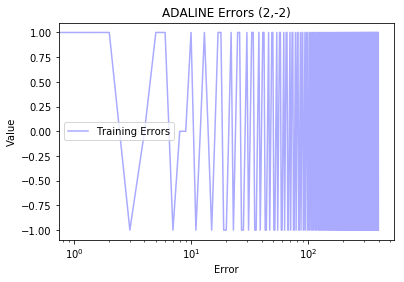

In [69]:
# Plot the errors to see how we did during training
ax = plt.subplot(111)
ax.plot(errors, c='#aaaaff', label='Training Errors')
ax.set_xscale("log")
plt.title("ADALINE Errors (2,-2)")
plt.legend()
plt.xlabel('Error')
plt.ylabel('Value')
plt.show()

### **Question 1**

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import math

LEARNING_RATE = 0.45

In [26]:
# Step function
def step(x):
    if (x > 0):
        return 1
    else:
        return 0
INPUTS = np.array([[0,0,1],
                   [0,1,1],
                   [1,0,1],
                   [1,1,1] ])
OUTPUTS = np.array([[0,1,1,1]]).T
np.random.seed(1)
WEIGHTS = 2*np.random.random((3,1)) - 1
print("Random Weights before training", WEIGHTS)

Random Weights before training [[-0.16595599]
 [ 0.44064899]
 [-0.99977125]]


In [27]:
errors=[]
for iter in range(100):

    for input_item,desired in zip(INPUTS, OUTPUTS):
        
        
        ADALINE_OUTPUT = (input_item[0]*WEIGHTS[0]) + (input_item[1]*WEIGHTS[1]) + (input_item[2]*WEIGHTS[2])

        
        ADALINE_OUTPUT = step(ADALINE_OUTPUT)

        
        ERROR = desired - ADALINE_OUTPUT
        errors.append(ERROR)
        
        # Update the weights based on the delta rule
        WEIGHTS[0] = WEIGHTS[0] + LEARNING_RATE * ERROR * input_item[0]
        WEIGHTS[1] = WEIGHTS[1] + LEARNING_RATE * ERROR * input_item[1]
        WEIGHTS[2] = WEIGHTS[2] + LEARNING_RATE * ERROR * input_item[2]

New Weights after training [[ 0.28404401]
 [ 0.89064899]
 [-0.09977125]]
Actual  0 Desired  [0]
Actual  1 Desired  [1]
Actual  1 Desired  [1]
Actual  1 Desired  [1]


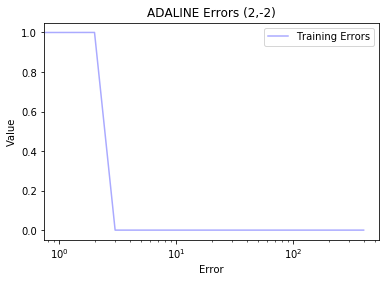

In [28]:
print("New Weights after training", WEIGHTS)
for input_item,desired in zip(INPUTS, OUTPUTS):
    
    ADALINE_OUTPUT = (input_item[0]*WEIGHTS[0]) + (input_item[1]*WEIGHTS[1]) + (input_item[2]*WEIGHTS[2])

    
    ADALINE_OUTPUT = step(ADALINE_OUTPUT)

    print("Actual ", ADALINE_OUTPUT, "Desired ", desired)

ax = plt.subplot(111)
ax.plot(errors, c='#aaaaff', label='Training Errors')
ax.set_xscale("log")
plt.title("ADALINE Errors (2,-2)")
plt.legend()
plt.xlabel('Error')
plt.ylabel('Value')
plt.show()
